In [8]:
#!/usr/bin/env python
# coding: utf-8

import os

default_n_threads = 1
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"



import netCDF4 as nc
import sys, os, argparse
import time
import numpy as np
from numpy import ma as ma

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from pylab import imshow,cm
#Import packages for plotting
from matplotlib.colors import ListedColormap

#Import packages for clustering
from sklearn.cluster import KMeans
from scipy.linalg import eigh
from scipy.interpolate import LinearNDInterpolator as LNDI

#Import packages for geodesic distences
from pyproj import Geod

# Import package for parallel computing
from joblib import Parallel, delayed

from scipy.interpolate import griddata

import cartopy.crs as ccrs 
import cartopy.feature as cfeature  

# Use the arguments in your script
year = 2009
season = "AMJ"
tmin = 29*4
print(f"Processing year {year}, season {season}")

IC_resolution = 0.5
dt = 0.0025
DT = 0.01
freq = 1
e = 0
#n_clusters = 20
# Format the variables
formatted_e = f"{e:.2f}"
formatted_DT = f"{DT:.4f}"
formatted_dt = f"{dt:.4f}"

# Construct file paths and directories
Fmap_params = f"{year}_{season}_"
Fmap_params += f"ic{IC_resolution}_"
Fmap_params += f"dt{formatted_dt}_"
Fmap_params += f"DT{formatted_DT}"
directory =  f"/cluster/projects/nn8008k/lluisa/NextSIM/seas/" #f"/nird/projects/NS11048K/lluisa/NextSIM/rotated_ice_velocities/seas/AMJ/"
file_path = f"{directory}Fmap_10days/{Fmap_params}/"
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
results_directory = file_path
regrided_geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}_regrided.nc"
geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}.nc"
K=10**7
distance = 0 #0
k_exp = 100
d=10000 #e=0
d_reweighted=10000 #e=0
d_disp=10000 #e=0
time_steps_per_day=4


Processing year 2009, season AMJ


In [9]:
if not os.path.exists(results_directory):
    os.makedirs(results_directory)


# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/utils")
sys.path.append(parent_directory+"/subfunctions/Parallelisation")
sys.path.append(parent_directory+"/subfunctions/latlon_transform") 
from parallelised_functions import split3D

sys.path.append(parent_directory+"/subfunctions/trajectory_advection")
from Interpolant import generate_land_mask_interpolator 

from from_similarity_to_eigen import from_similarity_to_eigen, from_similarity_to_eigen_W, cut_trajectories_in_W , cut_trajectories_in_3W, from_similarity_to_eigen_W_spard #, from_similarity_to_eigesut_zones

from ploters import ini_final_clusters
from ploters import gif_clusters
from ploters import ini_final_clusters_landmask
from ploters import ini_final_clusters_landmask_ini
from ploters import gif_clusters_landmask
from degrees import degree_matrix
from polar_rotation import polar_rotation_rx 

# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/subfunctions/border_calculation")
sys.path.append(parent_directory+"/utils")


#Import packages for geodesic distences 
from pyproj import Geod

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_construction")
sys.path.append(parent_directory+"/subfunctions/latlon_transform")
sys.path.append(parent_directory+"/utils")

#from trajectory_distance import integral_vec
#from similarity_matrix import similarity_matrix        #Commented out since they're currently in this script
from polar_rotation import polar_rotation_rx
from days_since_to_date import days_since_to_date



# ### Clustering
def kmeans(n_clusters,l_vect,Fmap,d):
    print("Applying k-means to define the clusters")

    l_vect_cut = l_vect[:,0:n_clusters]
    kmeans = KMeans(init="random",n_clusters=n_clusters,n_init=1000,max_iter=10000)
    kmeans.fit(l_vect_cut)
    labels = kmeans.labels_

    #np.save(results_directory+'/cut_Clusters_labels_'+Cluster_params+'.npy', labels)
    #np.save(results_directory+'/cut_Fmap_'+Cluster_params+'.npy', Fmap)


    print("Plotting the clusters")
    #ini_final_clusters(Fmap, n_clusters, labels, results_directory, "", e)
    #ini_final_clusters_landmask(Fmap, n_clusters, labels, results_directory+"clusters"+Cluster_params+"_0.png", e, longitude, latitude, land_mask)
    #ini_final_clusters_landmask_ini(Fmap, n_clusters, labels, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", e, longitude, latitude, land_mask)


    Cluster_params = (
        f"nclusters{n_clusters}_"
        f"d{d:.2f}"
    )

    #plot_clusters(Fmap, n_clusters, labels, results_directory+"cut0_clusters"+Cluster_params+"_ini.png", d, "tab20")
    return labels


def kmeans_3w(n_clusters,l_vect_reweighted,l_vect_disp,l_vect,Fmap,d):
    print("Applying k-means to define the clusters")

    kmeans = KMeans(init="random",n_clusters=n_clusters,n_init=1000,max_iter=10000)
    kmeans.fit(l_vect[:,0:n_clusters])
    labels = kmeans.labels_
    kmeans.fit(l_vect_reweighted[:,0:n_clusters])
    labels_reweighted = kmeans.labels_
    kmeans.fit(l_vect_disp[:,0:n_clusters])
    labels_disp = kmeans.labels_


    Cluster_params = (
        f"nclusters{n_clusters}_"
        f"d{d:.2f}"
    )

    #plot_clusters_3w(Fmap, n_clusters, labels_reweighted, labels_disp, labels, "tab20")
    return labels_reweighted, labels_disp, labels



In [10]:
IC_resolution = 0.5
dt = 0.0025
DT = 0.01
freq = 1
e = 0
n_clusters = 20
# Format the variables
formatted_e = f"{e:.2f}"
formatted_DT = f"{DT:.4f}"
formatted_dt = f"{dt:.4f}"

# Construct file paths and directories
Fmap_params = f"{year}_{season}_"
Fmap_params += f"ic{IC_resolution}_"
Fmap_params += f"dt{formatted_dt}_"
Fmap_params += f"DT{formatted_DT}"
directory =  f"/cluster/projects/nn8008k/lluisa/NextSIM/seas/" #f"/nird/projects/NS11048K/lluisa/NextSIM/rotated_ice_velocities/seas/AMJ/"
file_path = f"{directory}Fmap_10days/{Fmap_params}/"
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
results_directory = file_path
regrided_geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}_regrided.nc"
geo_file_path = f"{directory}OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}.nc"
K=1000
distance = 4
k_exp = 100

In [11]:
dataset = nc.Dataset(regrided_geo_file_path, mode='r')
#from m/s to m/day
siu = dataset.variables['vlon'][0,:,:]
land_mask_reg = dataset.variables['land_mask'][:,:]
# Access coordinates
latitude_reg = dataset.variables['regrided_rot_lat'][:]  
longitude_reg = dataset.variables['regrided_rot_lon'][:]
dataset.close()

dataset = nc.Dataset(geo_file_path, mode='r')
#from m/s to m/day
land_mask = dataset.variables['vlon'][0,:,:].mask
print("shape of land mask")
print(str(land_mask.shape))
# Access coordinates
latitude = dataset.variables['rot_lat'][:]  
longitude = dataset.variables['rot_lon'][:]
dataset.close()

# Define the 30 qualitative colors
colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3", "#8ca252", "#bd9e39", "#ad494a", "#a55194"
]
# Create a ListedColormap
cmap = ListedColormap(colors, name='qualitative_30')

shape of land mask
(492, 499)


In [12]:
def plot_clusters_3w_ftle(Fmap, spars, n_clusters, labels_reweighted, labels_disp, labels, cmap, img_name, tmin, time_data,X_domain_rot,Y_domain_rot,mask,ftle_dir):
    # Define a diverging colormap and normalization centered at 1 with an asymmetric range
    tmin_idx = int(tmin * 4)
    tmax_idx = int(tmin_idx + 10 * 4)
    t0 = time_data[0, tmin_idx]
    t1 = time_data[0, tmax_idx]
    cmap_ftle = "seismic"
    vmin = -0.1
    vmax = 0.1
    img_name = ftle_dir + '/' + str(tmin) + "_FTLE.png"
    FTLE = np.load(ftle_dir + str(tmin) + "_FTLE.npy")
    IC = Fmap[0, :, :]
    IC_lat, IC_lon = polar_rotation_rx(IC[1], IC[0], -90)
    positions_ini = np.asarray(np.vstack((IC_lon, IC_lat)))
    # Create a figure with four subplots side by side
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(
        1, 4,  # 1 row, 4 columns
        figsize=(32, 8),  # Adjust the figure size
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection
    )
    # Define a color map for the clusters
    colors = plt.get_cmap(cmap, n_clusters)
    # Plot the first subplot with w_reweighted
    ax1.scatter(positions_ini[0, :], positions_ini[1, :], c=labels_reweighted, cmap=colors, vmin=0, vmax=n_clusters - 1,
                transform=ccrs.PlateCarree(), s=8)
    ax1.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl1 = ax1.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl1.xlocator = plt.MultipleLocator(45)
    gl1.ylocator = plt.MultipleLocator(35)
    ax1.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax1.set_title("Re-weighted Lagrangian distance", fontsize=20)
    # Plot the second subplot with w_disp
    ax2.scatter(positions_ini[0, :], positions_ini[1, :], c=labels_disp, cmap=colors, vmin=0, vmax=n_clusters - 1,
                transform=ccrs.PlateCarree(), s=8)
    ax2.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl2 = ax2.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl2.xlocator = plt.MultipleLocator(45)
    gl2.ylocator = plt.MultipleLocator(35)
    ax2.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax2.set_title("Dispersion measure", fontsize=20)
    # Plot the third subplot with w_vec
    ax3.scatter(positions_ini[0, :], positions_ini[1, :], c=labels, cmap=colors, vmin=0, vmax=n_clusters - 1,
                transform=ccrs.PlateCarree(), s=8)
    ax3.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl3 = ax3.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl3.xlocator = plt.MultipleLocator(45)
    gl3.ylocator = plt.MultipleLocator(35)
    ax3.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax3.set_title("Lagrangian distance", fontsize=20)
    # Plot the FTLE data in ax4
    masked = np.array(mask.ravel())
    cax = ax4.scatter(
        np.asarray(X_domain_rot.ravel())[0, ~masked],
        np.asarray(Y_domain_rot.ravel())[0, ~masked],
        c=np.asarray(FTLE.ravel())[~masked],
        cmap=cmap_ftle,
        transform=ccrs.PlateCarree(),
        s=8,
        vmin=vmin,
        vmax=vmax
    )
    ax4.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl4 = ax4.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl4.ylocator = plt.MultipleLocator(35)
    ax4.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax4.set_title(r'$ \mathrm{FTLE}$'+f'$_{{{days_since_to_date(t0)}}}^{{{days_since_to_date(t1)}}}$', fontsize=24)
    # Add a separate axis for the colorbar
    cbar_ax = fig.add_axes([0.9, 0.05, 0.01, 0.8])  # [left, bottom, width, height]
    cbar = fig.colorbar(cax, cax=cbar_ax, ticks=np.linspace(vmin, vmax, 5))
    cbar.set_label('FTLE [$\mathrm{days^{-1}}$]', fontsize=18)
    cbar.ax.tick_params(labelsize=14)
    # Adjust layout and show the plot
    fig.suptitle("Nr clusters: "+str(n_clusters)+"    Sparsification parameter: "+str(spars)+"Km     tmin: "+str(tmin)+f'$, t_0={{{days_since_to_date(t0)}}},  t_1={{{days_since_to_date(t1)}}}$', fontsize=22)
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust layout to leave space for the colorbar
    plt.savefig(img_name, bbox_inches='tight')  # Save the figure if needed
    plt.show()
    plt.close(fig)  # Close the figure to free up memory

In [13]:
# Interpolate to a regular grid to then generate the interpolator objects
filename = f"OPA-neXtSIM_CREG025_ILBOXE140_{year}_ice_90Rx_{season}.nc"
directory = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/"
velocities_file_path = os.path.join(directory, filename)
reg_vel_file_path = velocities_file_path[:-3] + '_regrided.nc'
# Read dataset
print("Reading regrided input data")
dataset = nc.Dataset(reg_vel_file_path, mode='r')
regrided_land_mask = dataset.variables['land_mask'][:, :]
lat_grid = dataset.variables['regrided_rot_lat'][:]
lon_grid = dataset.variables['regrided_rot_lon'][:]
time_data = dataset.variables['time'][:]
time_data = np.reshape(time_data, (1, -1))
dataset.close()
lat_grid = lat_grid.filled()
lon_grid = lon_grid.filled()
lat_min, lat_max = lat_grid.min(), lat_grid.max()
lon_min, lon_max = lon_grid.min(), lon_grid.max()
dx = 0.1 # float
dy = 0.1 # float
x_domain = np.arange(lon_min, lon_max + dx, dx)
y_domain = np.arange(lat_min, lat_max + dy, dy)
X_domain, Y_domain = np.meshgrid(x_domain, y_domain)
X, Y = lon_grid, lat_grid
dx_data = X[0, 1] - X[0, 0]
dy_data = Y[1, 0] - Y[0, 0]
delta = [dx_data, dy_data]
mask_interpolator = LNDI(list(zip(lat_grid.ravel(), lon_grid.ravel())), regrided_land_mask.ravel(), fill_value=1)
mask = mask_interpolator(Y_domain, X_domain)
mask = np.asarray(mask).astype(bool)
Y_domain_rot, X_domain_rot = polar_rotation_rx(np.array(Y_domain), np.array(X_domain), -90)

print("Reading data")
#Read input data
Fmap_path = file_path+'/'+str(int(tmin/time_steps_per_day))+'_Fmap_matrix_cleaned.npy'
time_path = file_path+'/'+str(int(tmin/time_steps_per_day))+'_advection_time.npy'
W_path = file_path+'/'+str(int(tmin/time_steps_per_day))+'_W_matrix_cleaned.npy'
W_path_reweighted = file_path+'/'+str(int(tmin/time_steps_per_day))+'_W_reweighted_cleaned.npy'
W_path_disp = file_path+'/'+str(int(tmin/time_steps_per_day))+'_W_disp_cleaned.npy'

# Load the Fmap array from the file
Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
#Fmap=Fmap[:,:,::100]
# Load the time_adv_mod array from the file
time_adv_mod = np.load(time_path)
# Load the similarity matrix
W_vec = np.load(W_path)
w_disp = np.load(W_path_disp)
w_reweighted = np.load(W_path_reweighted)

dataset = nc.Dataset(regrided_geo_file_path, mode='r')
land_mask_reg = dataset.variables['land_mask'][:,:]
# Access coordinates
latitude_reg = dataset.variables['regrided_rot_lat'][:]  
longitude_reg = dataset.variables['regrided_rot_lon'][:]
dataset.close()


print("Cutting the trajectories that we don't want")
#W, Fmap_cut = cut_trajectories_in_W(Fmap, W_vec, distance,land_mask_reg,latitude_reg,longitude_reg)
#W_disp, Fmap_cut = cut_trajectories_in_W(Fmap, w_disp, distance,land_mask_reg,latitude_reg,longitude_reg)
#W_reweighted, Fmap_cut = cut_trajectories_in_W(Fmap, w_reweighted, distance,land_mask_reg,latitude_reg,longitude_reg)



Reading regrided input data
Reading data
Cutting the trajectories that we don't want


### Disconnected components in the clustering algorithm (0 eigenvalues)

In [18]:
distance = 0
spar = 10000

W, W_disp, W_reweighted, Fmap_cut = cut_trajectories_in_3W(Fmap, W_vec, w_disp, w_reweighted, distance,land_mask_reg,latitude_reg,longitude_reg,canadian=True, eastSval=True, canadian_greenland=True)

np.fill_diagonal(W,K)
np.fill_diagonal(W_disp,K)
np.fill_diagonal(W_reweighted,K)
print("Fmapcut")
print(Fmap_cut.shape)
print("Wshape")
print(W_disp.shape)
print("Computing eigenvalues of the diagonalized matrixxx")

formatted_distance = f"{distance:.2f}"

clusters_path = file_path+'/clusters_K'+str(K)+'_border'+str(formatted_distance)+'_cleaned_canadianfalse_spars/'
if not os.path.exists(clusters_path):
    os.makedirs(clusters_path)


print("Sparsification distance: ")
print(str(spar))
if spar==10000:
    z=0
    formatted_spar = f"{z:.2f}"
else:
    formatted_spar = f"{spar:.2f}"

l_vect_reweighted,l_reweighted,Fmap_cut_reweighted = from_similarity_to_eigen_W_spard(Fmap_cut,spar,W,W_reweighted,K,k_exp)
l_vect_disp,l_disp,Fmap_cut_disp = from_similarity_to_eigen_W_spard(Fmap_cut,spar,W,W_disp,K,k_exp)
l_vect,l,Fmap_cut_dist = from_similarity_to_eigen_W_spard(Fmap_cut,spar,W,W,K,k_exp)


Number of points inside the polygons:
125384
Finally finished generating interpolator!
(1583,) trajectories have been removed because they were too close to land or ending up too close to land
Fmapcut
(976, 2, 2233)
Wshape
(2233, 2233)
Computing eigenvalues of the diagonalized matrixxx
Sparsification distance: 
10000
No sparsification
(0,) trajectories have been removed because they were not similar to any other trajectories
Computing first 100 eigenvalues
No sparsification
(0,) trajectories have been removed because they were not similar to any other trajectories
Computing first 100 eigenvalues
No sparsification
(0,) trajectories have been removed because they were not similar to any other trajectories
Computing first 100 eigenvalues


NameError: name 'a' is not defined

In [19]:
Fmap_cut

array([[[-102.90638733, -101.90638733, -101.90638733, ...,
          -83.40638733,  -82.90638733,  -82.40638733],
        [ -15.47213745,  -15.47213745,  -14.97213745, ...,
           21.52786255,   22.02786255,   22.02786255]],

       [[-102.90638758, -101.90625218, -101.90637666, ...,
          -83.40638733,  -82.90638733,  -82.40638733],
        [ -15.47213744,  -15.47156423,  -14.9712584 , ...,
           21.52786255,   22.02786255,   22.02786255]],

       [[-102.90638783, -101.90610762, -101.90634983, ...,
          -83.40638733,  -82.90638733,  -82.40638733],
        [ -15.47213743,  -15.47098389,  -14.97037822, ...,
           21.52786255,   22.02786255,   22.02786255]],

       ...,

       [[-102.90640548, -101.84577403, -101.85486956, ...,
          -83.40638663,  -82.90638688,  -82.40638701],
        [ -15.47213612,  -15.58404525,  -15.20136327, ...,
           21.52786272,   22.02786257,   22.02786248]],

       [[-102.9064056 , -101.84558855, -101.85454552, ...,
        

In [20]:
clusters_path+'tmin'+str(int(tmin/time_steps_per_day))+'_spar'+str(formatted_spar)+'_labels'+'_Fmap_cut.npy'

'/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/2009_AMJ_ic0.5_dt0.0025_DT0.0100//clusters_K1000_border0.00_cleaned_canadianfalse_spars/tmin29_spar0.00_labels_Fmap_cut.npy'

In [21]:
np.save(clusters_path+'tmin'+str(int(tmin/time_steps_per_day))+'_spar'+str(formatted_spar)+'_labels'+'_Fmap_cut.npy',Fmap_cut_dist)


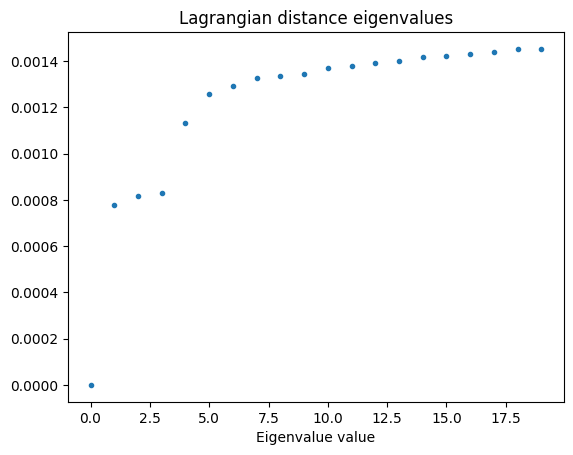

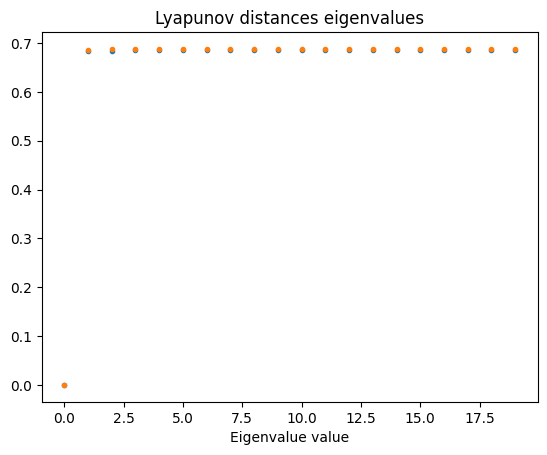

Clustering
Applying k-means to define the clusters
Saving results
Applying k-means to define the clusters
Saving results
Applying k-means to define the clusters
Saving results
Applying k-means to define the clusters
Saving results
Applying k-means to define the clusters
Saving results


In [22]:

plt.plot(l[0:20],'.')
plt.xlabel("Eigenvalue index")
plt.xlabel("Eigenvalue value")
plt.title("Lagrangian distance eigenvalues")
plt.show()
plt.close()


plt.plot(l_disp[0:20],'.')
plt.plot(l_reweighted[0:20],'.')
plt.xlabel("Eigenvalue index")
plt.xlabel("Eigenvalue value")
plt.title("Lyapunov distances eigenvalues")
plt.show()
plt.close()

print("Clustering")
for n_clusters in (5,10,15,20,25):
#n_clusters = 9
#for n_clusters in range(20,100,20):
#if not os.path.exists(clusters_path+str(n_clusters)+'_Fmap_cut.npy'):  
    labels_reweighted, labels_disp, labels = kmeans_3w(n_clusters,l_vect_reweighted,l_vect_disp,l_vect,Fmap_cut_dist,d)

    print("Saving results")
    np.save(clusters_path+str(n_clusters)+'_tmin'+str(int(tmin/time_steps_per_day))+'_spar'+str(formatted_spar)+'_labels.npy',labels)
    np.save(clusters_path+str(n_clusters)+'_tmin'+str(int(tmin/time_steps_per_day))+'_spar'+str(formatted_spar)+'_labels_disp.npy',labels_disp)
    np.save(clusters_path+str(n_clusters)+'_tmin'+str(int(tmin/time_steps_per_day))+'_spar'+str(formatted_spar)+'_labels_reweighted.npy',labels_reweighted)

    tmin2=int(tmin/4)
    #ftle_dir = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap_10days/cleaned_FTLE_"+str(year)+"_"+season+"_dx0.100_dy0.100_dt0.100_grid_ratio0.010/"
    #plot_clusters_3w_ftle(Fmap_cut_dist, spar, n_clusters, labels_reweighted, labels_disp, labels, cmap,"",tmin2,time_data,X_domain_rot,Y_domain_rot,mask,ftle_dir) #clusters_dir+str(20)+"clusters_tmin0.png")

